In [1]:
# Note: running server with north-america-latest map takes about 24 GB of RAM

# Import stuff
import os
from typing import Dict, Any, List, Tuple

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import folium
import polyline

In [2]:
# Set working directory
%cd ~/projects/blog_posts/osrm-blog/

/Users/ecotner/projects/blog_posts/osrm-blog


In [8]:
print(os.environ['EXTERNAL_IP'])

35.245.132.58


### Define convenience functions and OSRM connection object

In [9]:
from typing import Dict, Any

import requests

def format_coords(coords: np.ndarray) -> str:
    """
    Formats numpy array of (x,y) coordinates into a concatenated string formatted
    for the OSRM server.
    """
    coords = ";".join([f"{lon:f},{lat:f}" for lat, lon in coords])
    return coords

def format_options(options: Dict[str, str]) -> str:
    """
    Formats dictionary of additional options to your OSRM request into a
    concatenated string format.
    """
    options = "&".join([f"{k}={v}" for k, v in options.items()])
    return options

class Connection:
    """Interface for connecting to and interacting with OSRM server.
    
    Default units from raw JSON response are in meters for distance and seconds for
    time. I will convert these to miles/hours respectively.
    """
    METERS_PER_MILE = 1609.344
    SEC_PER_HOUR = 3600
    def __init__(self, host: str, port: str):
        self.host = host
        self.port = port
        # Test connection?
    
    def make_request(
            self,
            service: str,
            coords: np.ndarray,
            options: dict=None
        ) -> Dict[str, Any]:
        """
        Forwards your request to the OSRM server and returns a dictionary of the JSON
        response.
        """
        coords = format_coords(coords)
        options = format_options(options) if options else ""
        url = f"http://{self.host}:{self.port}/{service}/v1/car/{coords}?{options}"
        r = requests.get(url)
        return r.json()
    
    def route_dt(self, coords: np.ndarray):
        """Returns the distance/time to travel a given route.
        """
        x = self.make_request(
            service='route',
            coords=coords,
            options={'steps': 'false', 'overview': 'false'}
        )
        x = x['routes'][0]
        return (x['distance']/self.METERS_PER_MILE, x['duration']/self.SEC_PER_HOUR)
    
    def route_polyline(self, coords: np.ndarray, resolution='low'
        ) -> List[Tuple[float, float]]:
        """Returns polyline of route path as a list of (lat, lon) coordinates.
        """
        assert resolution in ('low', 'high')
        if resolution == 'low':
            options = {'overview': 'simplified'}
        elif resolution == 'high':
            options = {'overview': 'full'}
        x = self.make_request(service='route', coords=coords, options=options)
        return polyline.decode(x['routes'][0]['geometry'])

In [55]:
# Set up a connection
conn = Connection(host=os.environ['EXTERNAL_IP'], port="80")
# Test it out with some random data
coords = 0.01*np.random.randn(2, 2) + np.array([[39.742933, -104.986378]])
print(conn.route_dt(coords), end='\n\n')
print(conn.route_polyline(coords, resolution='low'))

(0.7367598226358069, 0.03994444444444445)

[(39.74477, -104.97789), (39.74485, -104.97789), (39.74485, -104.97874), (39.74325, -104.97874), (39.74323, -104.96969), (39.74187, -104.96969)]


In [56]:
# Here's an example of a raw response object
# Try out different options and examine components of the JSON object returned
x = conn.make_request(
    service='route', 
    coords=coords, 
    options={'steps': 'false', 'overview': 'false'}
)

In [57]:
x.keys()

dict_keys(['code', 'routes', 'waypoints'])

In [60]:
x['routes'][0]

{'legs': [{'steps': [],
   'distance': 1185.7,
   'duration': 143.8,
   'summary': '',
   'weight': 145.9}],
 'distance': 1185.7,
 'duration': 143.8,
 'weight_name': 'routability',
 'weight': 145.9}

## Import delivery route data

In [61]:
raw_df = pd.read_csv('delivery_data.csv')
raw_df['arrival_time'] = pd.to_datetime(raw_df['arrival_time'])
raw_df['departure_time'] = pd.to_datetime(raw_df['departure_time'])
raw_df.head()

,route_id,latitude,longitude,arrival_time,departure_time
0,A,35.237665,-81.343199,2019-11-11 12:53:22,2019-11-11 13:10:00
1,A,35.274080,-81.520423,2019-11-11 13:28:46,2019-11-11 13:31:06
2,A,35.286103,-81.540567,2019-11-11 13:45:13,2019-11-11 13:50:48
3,A,35.290060,-81.535398,2019-11-11 13:56:34,2019-11-11 13:59:23
4,A,35.326816,-81.758327,2019-11-11 14:18:30,2019-11-11 14:22:12


### Analyze and characterize the data

In [62]:
print(f"Total # rows: {len(raw_df)}")
print("# null elements:")
raw_df.isna().sum()

Total # rows: 377
# null elements:


route_id           0
latitude           0
longitude          0
arrival_time      26
departure_time    26
dtype: int64

In [63]:
# Take a look at some of the null rows
raw_df[raw_df.isna().any(axis=1)].head(8)

,route_id,latitude,longitude,arrival_time,departure_time
16,A,35.237393,-80.974431,2019-11-11 18:46:11,NaT
17,A,35.237393,-80.974431,NaT,2019-11-11 12:00:20
31,B,35.237393,-80.974431,2019-11-11 16:56:57,NaT
32,B,35.237393,-80.974431,NaT,2019-11-11 12:24:31
42,C,35.237393,-80.974431,2019-11-11 21:12:11,NaT
43,C,35.237393,-80.974431,NaT,2019-11-11 17:02:47
56,D,35.237393,-80.974431,2019-11-11 15:40:38,NaT
57,D,35.237393,-80.974431,NaT,2019-11-11 12:33:22


Looks like the null values are simply because the truck arrives and departs from the warehouse, but not as part of the same stop. Let's fill in these null values with whatever the non-null time is from the same row.

In [17]:
stops_df = raw_df.copy()
stops_df['arrival_time'].fillna(stops_df['departure_time'], inplace=True)
stops_df['departure_time'].fillna(stops_df['arrival_time'], inplace=True)

In [18]:
stops_df.isna().any()

route_id          False
latitude          False
longitude         False
arrival_time      False
departure_time    False
dtype: bool

Good! We can also assign a sequence order to these stops so we can see at a glance what order they occurred in.

In [19]:
df = list()
for route_id, group in stops_df.groupby('route_id'):
    group = group.sort_values(by='arrival_time')
    group['seq_num'] = list(range(len(group)))
    df.append(group)
stops_df = pd.concat(df, axis=0)

In [20]:
stops_df.head()

,route_id,latitude,longitude,arrival_time,departure_time,seq_num
17,A,35.237393,-80.974431,2019-11-11 12:00:20,2019-11-11 12:00:20,0
0,A,35.237665,-81.343199,2019-11-11 12:53:22,2019-11-11 13:10:00,1
1,A,35.274080,-81.520423,2019-11-11 13:28:46,2019-11-11 13:31:06,2
2,A,35.286103,-81.540567,2019-11-11 13:45:13,2019-11-11 13:50:48,3
3,A,35.290060,-81.535398,2019-11-11 13:56:34,2019-11-11 13:59:23,4


Let's take a look at a histogram of the arrival time of these deliveries.

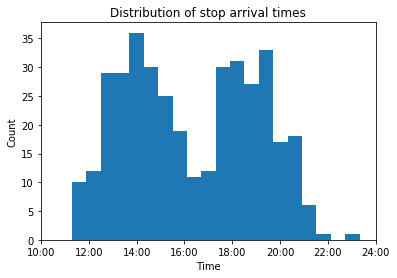

In [21]:
x = stops_df['arrival_time']
x = x.dt.hour + x.dt.minute/60 + x.dt.second/3600
plt.hist(x, bins=20)
plt.title("Distribution of stop arrival times")
locs, _ = plt.xticks()
plt.xticks(locs, [f"{int(h)}:00" for h in locs])
plt.xlabel('Time')
plt.ylabel('Count')
plt.show()

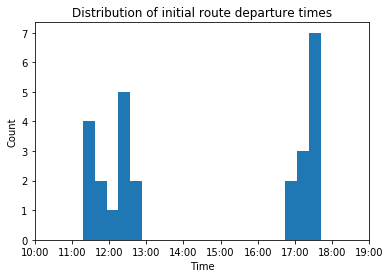

In [22]:
x = stops_df.groupby('route_id')['departure_time'].min()
x = x.dt.hour + x.dt.minute/60 + x.dt.second/3600
plt.hist(x, bins=20)
plt.title("Distribution of initial route departure times")
locs, _ = plt.xticks()
plt.xticks(locs, [f"{int(h)}:00" for h in locs])
plt.xlabel('Time')
plt.ylabel('Count')
plt.show()

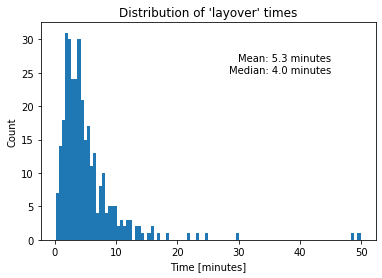

In [23]:
x = stops_df['departure_time'] - stops_df['arrival_time']
x = x.dt.seconds/60
x = x[x != 0]
plt.hist(x, bins=100)
plt.title("Distribution of 'layover' times")
text = (f"Mean: {np.mean(x):.1f} minutes\n"
    f"Median: {np.median(x):.1f} minutes")
plt.text(45, 25, text, horizontalalignment='right')
plt.xlabel('Time [minutes]')
plt.ylabel('Count')
plt.show()

Looks like there are two delivery periods, one around noon, and another in the afternoon.

Alright, let's visualize the actual geospatial layout of the delivery stops

In [24]:
m = folium.Map(location=stops_df[['latitude','longitude']].mean(), zoom_start=8)
for _, row in stops_df.iterrows():
    lat, lon = row['latitude'], row['longitude']
    folium.Marker(
        location=(lat, lon),
        popup=f"({lat:.4f}, {lon:.4f})"
    ).add_to(m)
m

In [25]:
m.save("all-customers.html")

That looks a little cluttered. Let's focus on a single route and visualize the path that was taken.

In [26]:
df = stops_df[stops_df['route_id'] == 'A'].copy()
df.sort_values(by='seq_num', inplace=True)
# Create map
m = folium.Map(location=df[['latitude','longitude']].mean(), zoom_start=9)
# Add polyline between stops
folium.PolyLine(
    locations=df[['latitude','longitude']].values,
    tooltip="Route A",
    color='#0fa6d9',
    opacity=0.35,
).add_to(m)
# Create location markers for stops
for _, row in df.iterrows():
    lat, lon = row['latitude'], row['longitude']
    folium.CircleMarker(
        location=(lat, lon),
        popup=f"({lat:.4f}, {lon:.4f})",
        tooltip=row['seq_num'],
        fill=True,
        radius=4,
        fill_opacity=0.5,
        color='#0fa6d9',
    ).add_to(m)
m

In [27]:
m.save("single-route-simple.html")

This is great, but the point-to-point paths do not actually give us a good sense of the actual distance or time it takes to drive from one point to another. But this is where OSRM comes in! We can submit the stop coordinates to the OSRM `route` service and have it return a polyline which will give us the the path (probably) taken to drive between the locations.

In [31]:
df = stops_df[stops_df['route_id'] == 'A'].copy()
df.sort_values(by='seq_num', inplace=True)
# Create map
m = folium.Map(location=df[['latitude','longitude']].mean(), zoom_start=9)
# Get polyline from OSRM
coords = df[['latitude','longitude']].values
route_polyline = conn.route_polyline(coords, resolution='high')
# Add polyline between stops
folium.PolyLine(
    locations=route_polyline,
    tooltip="Route A",
    color='#0fa6d9',
    opacity=0.75
).add_to(m)
# Create location markers for stops
for _, row in df.iterrows():
    lat, lon = row['latitude'], row['longitude']
    popup = folium.Popup(f"({lat:.4f}, {lon:.4f})", max_width=9999)
    folium.CircleMarker(
        location=(lat, lon),
        popup=popup,
        tooltip=row['seq_num'],
        radius=4,
        fill=True,
        fill_opacity=.25,
        color='#0fa6d9',
    ).add_to(m)
m

In [32]:
m.save("single-route.html")

Alright, that's pretty cool. But we can do even better. Let's use OSRM to calculate the distance and time between each stop and add this as a popup when you click on the route, and then do this for ALL the routes!

I'll separate them into AM and PM routes so we don't get as much overlap on the map.

In [48]:
df = stops_df[stops_df['seq_num']==0]
mask = df['departure_time'] < pd.Timestamp('2019-11-11 14:00:00')
am_route_ids = df[mask]['route_id'].unique()
pm_route_ids = df[~mask]['route_id'].unique()

In [51]:
maps = dict()
for key, route_ids in zip(['AM','PM'], [am_route_ids, pm_route_ids]):
    df = stops_df[stops_df['route_id'].isin(route_ids)]
    # Create map
    maps[key] = folium.Map(
        location=df[['latitude','longitude']].mean(),
        zoom_start=8
    )
    # Iterate over route ID's
    for route_id, group in df.groupby('route_id'):
        # Order route stops, choose random color
        group = group.sort_values(by='seq_num')
        color = np.random.choice([
            "#ff0000", # red
            "#ff9500", # orange
            "#ffd900", # yellow
            "#73ff00", # green
            "#00ffd5", # teal
            "#00c3ff", # light blue
            "#0022ff", # dark blue
            "#9d00ff", # purple
            "#ff00ee", # pink
            "#ff00a2", # magenta?
        ])
        # Get polylines from OSRM
        for i in range(len(group)-1):
            coords = group[['latitude','longitude']].values[i:i+2]
            route_polyline = np.array(conn.route_polyline(
                coords, resolution='high'
            ))
            d, t = conn.route_dt(coords)
            # Add polyline between stops
            folium.PolyLine(
                locations=route_polyline,
                tooltip=f"Route {route_id}",
                popup=f"Distance: {d:.2f} mi., duration: {60*t:.1f} min.",
                color=color,
                opacity=0.35,
            ).add_to(maps[key])
        # Create location markers for stops
        for _, row in group.iterrows():
            lat, lon = row['latitude'], row['longitude']
            arrival = row['arrival_time'].strftime("%H:%M")
            departure = row['departure_time'].strftime("%H:%M")
            if row['seq_num'] % (len(group)-1) == 0:
                folium.Marker(
                    location=(lat, lon),
                    tooltip='Charlotte DC',
                    popup=folium.Popup(f"({lat:.4f}, {lon:.4f})", max_width=9999),
                    icon=folium.Icon(color='black', icon='home'),
                ).add_to(maps[key])
            else:
                folium.CircleMarker(
                    location=(lat, lon),
                    tooltip=f"{route_id}-{row['seq_num']}",
                    popup=f"({lat:.4f}, {lon:.4f})\n{arrival}-{departure}",
                    radius=4,
                    fill=True,
                    fill_opacity=.5,
                    color=color,
                ).add_to(maps[key])

In [52]:
maps['AM']

In [53]:
maps['PM']

In [54]:
for key in maps:
    maps[key].save(f'full-{key}-route-map.html')

Thanks for checking out the blog post!

-Eric